# EPR pair

This notebook illustrates the reconstruction of the covariance matrix of an EPR pair. The EPR pair is generated by combining two single-mode squeezed vacuum states on a 50:50 beam splitter. The two squeezed states have orthogonal squeezing angles, offset by $\frac{\pi}{2}$ (i.e., one is position-squeezed and the other is momentum-squeezed). Interference on the beam splitter produces two output modes that are entangled in the continuous-variable quadratures.

![Schematics of EPR pair](./img/epr.png)

In [8]:
from phase_scan import gaussian_utils
from phase_scan.ml_estimation import ml_covariance_estimation
from phase_scan.gmm_estimation import gmm_covariance_estimation
from phase_scan.utils import triangle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import scipy as sp
from scipy.stats import norm

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

## Covariance matrix of the EPR state

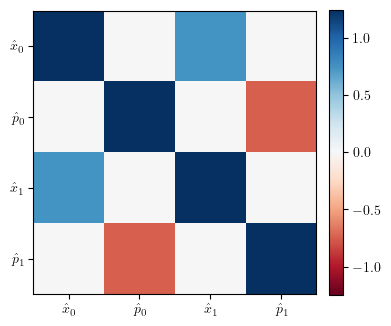

In [9]:
squeezing_dB = 3
squeezing_s = 10 ** (-squeezing_dB / 10)

s = gaussian_utils.squeezed_vacuum(squeezing_s)
sigma = sp.linalg.block_diag(s, s)

R = sp.linalg.block_diag(*[gaussian_utils.rotation_symplectic(angle) for angle in [0, np.pi / 2]])
BS = gaussian_utils.bs_symplectic(0.5)
R_BS = BS@R
sigma = R_BS@sigma@R_BS.T

gaussian_utils.plot_covariance_matrix(sigma, show_var_names=True)
plt.show()

## Quadrature samples obtained by scanning

A different modulation frequency is chosen for the two homodyne, collecting quadratures samples at unrelated angles. The states produced at the output of the beam splitter do no longer any squeezing - the variance of the quadrature samples does not depend on the scanning angle.

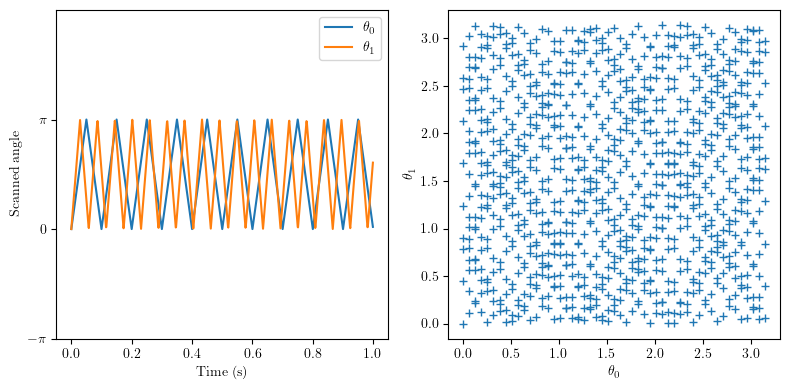

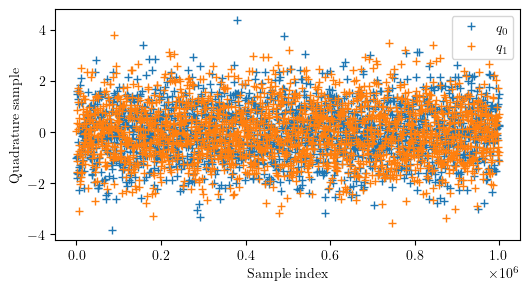

In [10]:
# Scanning angles
N_angles = 1000
t = np.arange(N_angles) / N_angles
angles = np.zeros((N_angles, 2))
angles[:, 0] = np.pi * triangle(t, 10)
angles[:, 1] = np.pi * triangle(t, 10 * np.sqrt(3))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(t, angles)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Scanned angle')
axs[0].set_ylim([-np.pi, 2*np.pi])
axs[0].set_yticks([-np.pi, 0, np.pi], ['$-\\pi$', '0', '$\\pi$'])
axs[0].legend(['$\\theta_0$', '$\\theta_1$'])
axs[1].plot(angles[:, 0], angles[:, 1], '+')
axs[1].set_xlabel('$\\theta_0$')
axs[1].set_ylabel('$\\theta_1$')
plt.tight_layout()
plt.show()

# Generation of quadrature samples at these angles
samples = gaussian_utils.generate_scanned_samples(
    sigma,
    angles,
    gaussian_utils.generate_samples_parallel,
    samples_per_angle=1000)

corrcoeff = np.zeros((len(samples), ))
for i, (angle, block) in enumerate(samples):
    corrcoeff[i] = np.corrcoef(block.T)[0][1]

samples_flat = np.vstack([s for _, s in samples])
skip = 500
plt.figure(figsize=(6, 3))
plt.plot(np.arange(0, samples_flat.shape[0], skip), samples_flat[::skip, :], '+')
plt.xlabel('Sample index')
plt.ylabel('Quadrature sample')
plt.legend(['$q_0$', '$q_1$'])
plt.show()

## ML estimation of the covariance matrix from $(\theta_0, \theta_1, q_0, q_1)$

Optimizing...:   0%|          | 0/1000 [00:00<?, ?it/s]

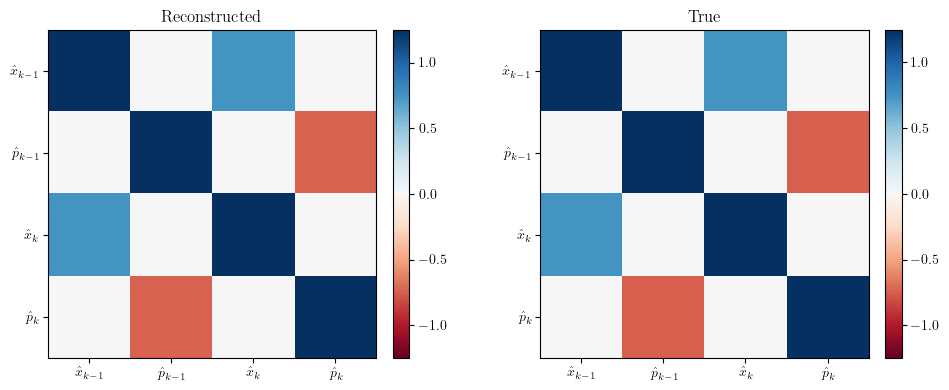

In [35]:
estimated_sigma = ml_covariance_estimation(samples, lr=0.05, max_iterations=1_000)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
gaussian_utils.plot_covariance_matrix(
    sigma, title='True', show_var_names=True, sequential=True, axs=axs[1])
gaussian_utils.plot_covariance_matrix(
    estimated_sigma, title='Reconstructed', show_var_names=True, sequential=True, axs=axs[0]) 
plt.tight_layout()
plt.show()

### And now with least-squares

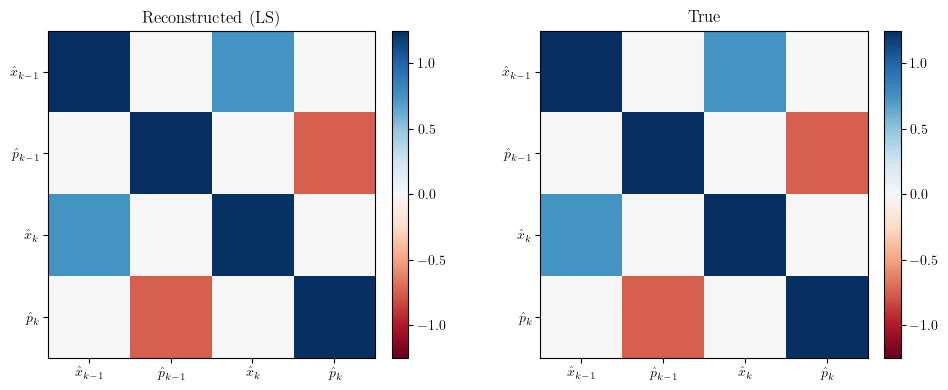

In [15]:
estimated_sigma_ls = gmm_covariance_estimation(samples, num_steps=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
gaussian_utils.plot_covariance_matrix(
    sigma, title='True', show_var_names=True, sequential=True, axs=axs[1])
gaussian_utils.plot_covariance_matrix(
    estimated_sigma_ls, title='Reconstructed (LS)', show_var_names=True, sequential=True, axs=axs[0]) 
plt.tight_layout()
plt.show()